# The Titanic Problem

In [1]:
# Import the relevant libaries, start with a few and expand as you go along

import pandas as pd
import numpy as np


In [2]:
# Defined from problem tutorial:

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Equally, this is defined in the Tutorial so will need revisiting to fully understand

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = Train.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [4]:
# Load in the two sets (test and training)
Test = pd.read_csv('test.csv')
Train = pd.read_csv('train.csv')

In [5]:
# Use 'append' to essentially concatenate the test set to the training set
Full = Train.append(Test, ignore_index = True)

# Note: ignore_index set to true ignores index, default false

### Data Exploration & Learning Commands

In [6]:
# Shapes is used to output the row and column lengths
Shapes = [Test.shape, Train.shape, Full.shape]

In [7]:
# Print the results of each shape into a readable format
print('Test Dataset:', Shapes[0], '| Train Dataset:', Shapes[1], '| Full Dataset:', Shapes[2])

Test Dataset: (418, 11) | Train Dataset: (891, 12) | Full Dataset: (1309, 12)


In [8]:
# Timeit can be used to determine the most efficient way to solve issues :

In [9]:
timeit len(Test.index)

967 ns ± 54.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
timeit len(Test.index)

966 ns ± 69.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
timeit Test.shape

1.67 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [12]:
timeit Test.count()

765 µs ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# So from here, you can see len.index is the quickest, and count the slowest

### Data Exploration prt 2

In [14]:
# Use head / tail to see a snippet of the dataa
Train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# Super usful
Train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [53]:
# Extra Note: np.unique can be used to pull out the unique values in a field
a = np.unique(Full['SibSp'])

# Similar but for null values too
b1 = np.array(list(Full['Embarked']))
b = np.unique(b1)

print(a)
print(b)

[0 1 2 3 4 5 8]
['C' 'Q' 'S' 'nan']


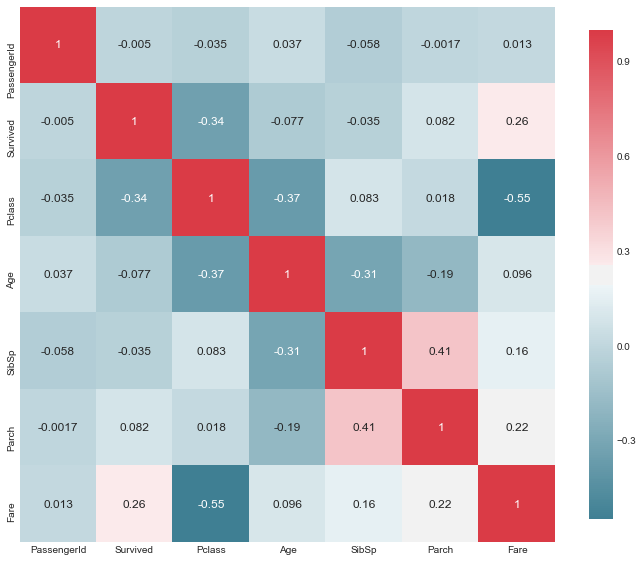

In [16]:
# Pull the previously defined plot to create a heatmap to find correlations

plot_correlation_map( Train )

### Exploring Possible Variables

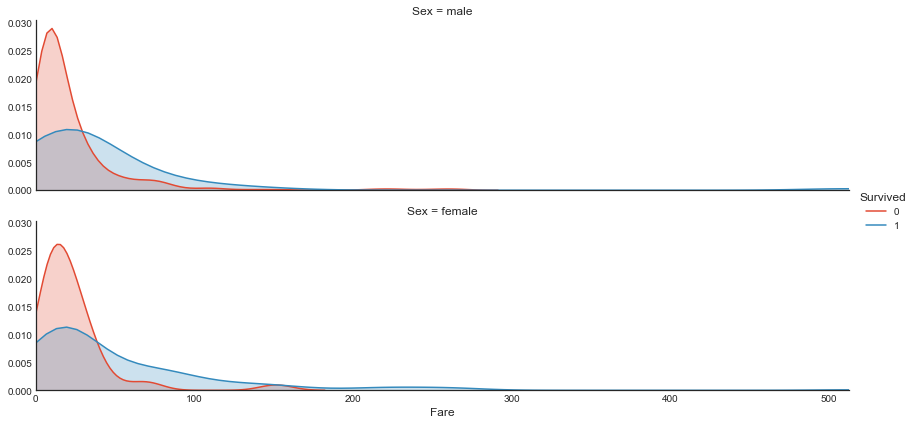

In [17]:
# Plot different distributions of Age of passengers who did or didn't survive vs different metrics

# Fare

plot_distribution( Train , var = 'Fare' , target = 'Survived' , row = 'Sex' )

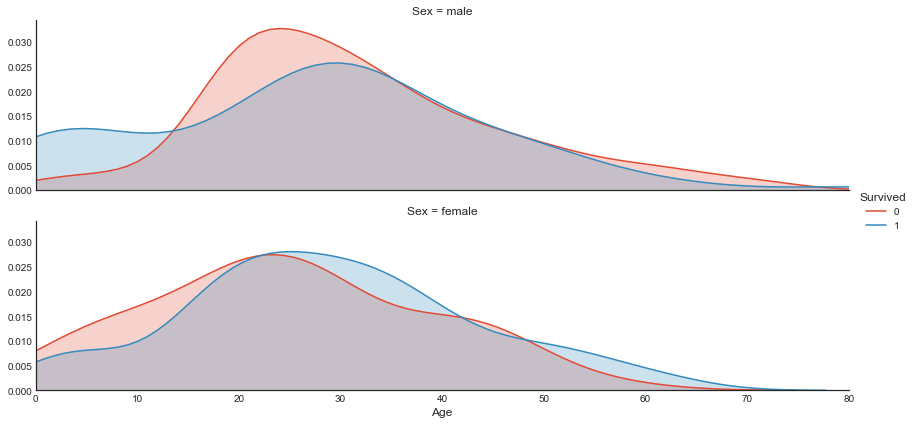

In [18]:
# Age

plot_distribution( Train , var = 'Age' , target = 'Survived' , row = 'Sex' )

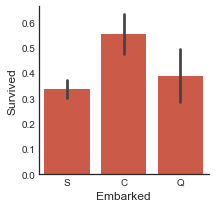

In [19]:
# We can also plot categories as well as distributions

# Embarked

plot_categories( Train , cat = 'Embarked' , target = 'Survived' )

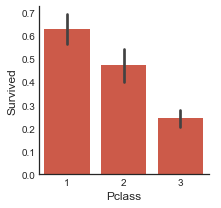

In [20]:
# Pclass (Passenger Class)

plot_categories( Train , cat = 'Pclass' , target = 'Survived' )

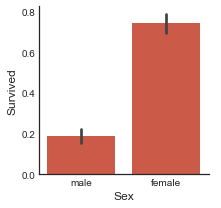

In [21]:
# Sex

plot_categories( Train , cat = 'Sex' , target = 'Survived' )

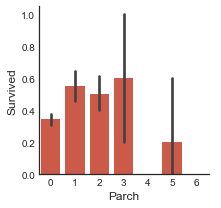

In [22]:
# Parch (Number of parents / children aboard)

plot_categories( Train , cat = 'Parch' , target = 'Survived' )

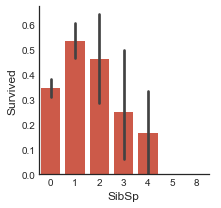

In [23]:
# SibSp (Number of siblings aboard)

plot_categories( Train , cat = 'SibSp' , target = 'Survived' )

### Data Manipulation

In [24]:
# First step - Transforming Categorical data into 1s and 0s

# Transform Sex into binary values 0 and 1

sex = pd.Series( np.where( Full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [25]:
# Create a new variable for every unique value of Embarked

embarked = pd.get_dummies( Full.Embarked , prefix='Embarked' )

embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [26]:
# Create a new variable for every unique value of Pclass

pclass = pd.get_dummies( Full.Pclass , prefix='Pclass' )

pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [29]:
# Second step - Create a dataset to fill in missing / null values 

# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed['Age'] = Full.Age.fillna( Full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed['Fare'] = Full.Fare.fillna( Full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


### Feature Engineering – Creating new variables

In [97]:
# Feature engineering is the process of narrowing down / creating new variables
Full['Name'].head(5)

## Notice the data is very clean, the title is always the second word, after the comma and followed by a period

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [98]:
# Open an empty dataframe
title = pd.DataFrame()

#Now we can extract the title from each name
title[ 'Title' ] = Full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# and show the unique values
print(np.unique(title))

# Create a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# Then we can map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )

title = pd.get_dummies( title.Title )

title.tail()

['Capt' 'Col' 'Don' 'Dona' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss'
 'Mlle' 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'the Countess']


,Master,Miss,Mr,Mrs,Officer,Royalty
1304,0,0,1,0,0,0
1305,0,0,0,0,0,1
1306,0,0,1,0,0,0
1307,0,0,1,0,0,0
1308,1,0,0,0,0,0
